In [1]:
import pandas as pd

In [2]:
X_train = pd.read_csv("data/X_train.csv")
X_train["Species"].value_counts()

Species
Ryegrass_Clover                                                98
Ryegrass                                                       62
Phalaris_Clover                                                42
Clover                                                         41
Fescue                                                         28
Lucerne                                                        22
Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed    11
Fescue_CrumbWeed                                               10
WhiteClover                                                    10
Phalaris_Ryegrass_Clover                                        8
Phalaris                                                        8
Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass                 7
SubcloverLosa                                                   5
SubcloverDalkeith                                               3
Mixed                                                           2
Na

## Correlation analysis

#### Height and NVDI

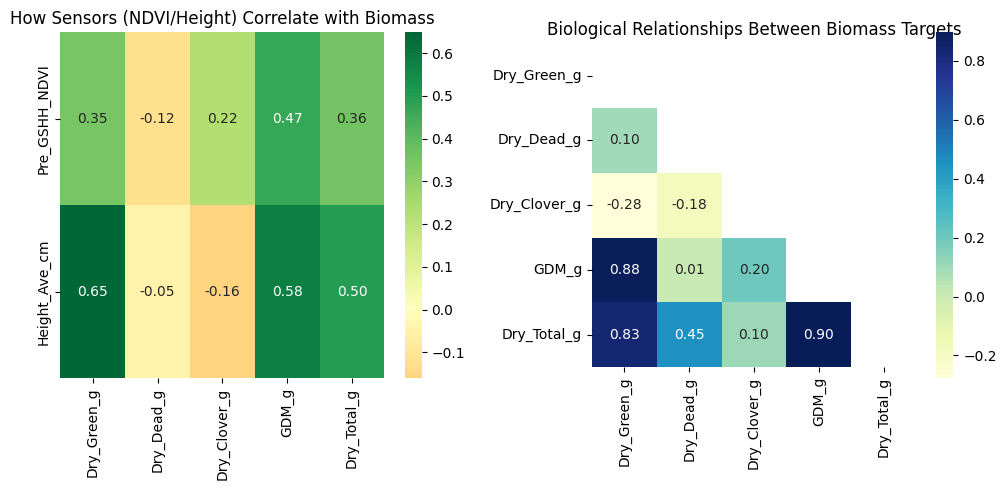

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Final

# 1. Setup Constants
FEATURES: Final = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
TARGETS: Final = ["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]

# 2. Load and Merge
X, y = pd.read_csv("./data/X_train.csv"), pd.read_csv("./data/y_train.csv")
combined_df = pd.merge(X, y, on="image_id")

# 3. Calculate Matrices
# Full correlation of all variables of interest
full_corr = combined_df[FEATURES + TARGETS].corr()

# Slice A: How features affect targets
feature_target_corr = full_corr.loc[FEATURES, TARGETS]

# Slice B: How targets affect each other
target_inter_corr = full_corr.loc[TARGETS, TARGETS]

# 4. Plotting using a 2-row layout
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Top Plot: Features vs Targets
sns.heatmap(feature_target_corr, annot=True, cmap="RdYlGn", center=0, fmt=".2f", ax=ax1)
ax1.set_title("How Sensors (NDVI/Height) Correlate with Biomass")

# Bottom Plot: Inter-target relationships
# We use a mask to hide the upper triangle for better clarity on the 5x5 matrix
mask = np.triu(np.ones_like(target_inter_corr, dtype=bool))

sns.heatmap(
    target_inter_corr,
    mask=mask,
    annot=True,
    cmap="YlGnBu",  # Different color to distinguish the two charts
    fmt=".2f",
    ax=ax2,
    square=True,
)
ax2.set_title("Biological Relationships Between Biomass Targets")

plt.tight_layout()
plt.savefig("./results/combined_correlations.png")

#### State Analysis

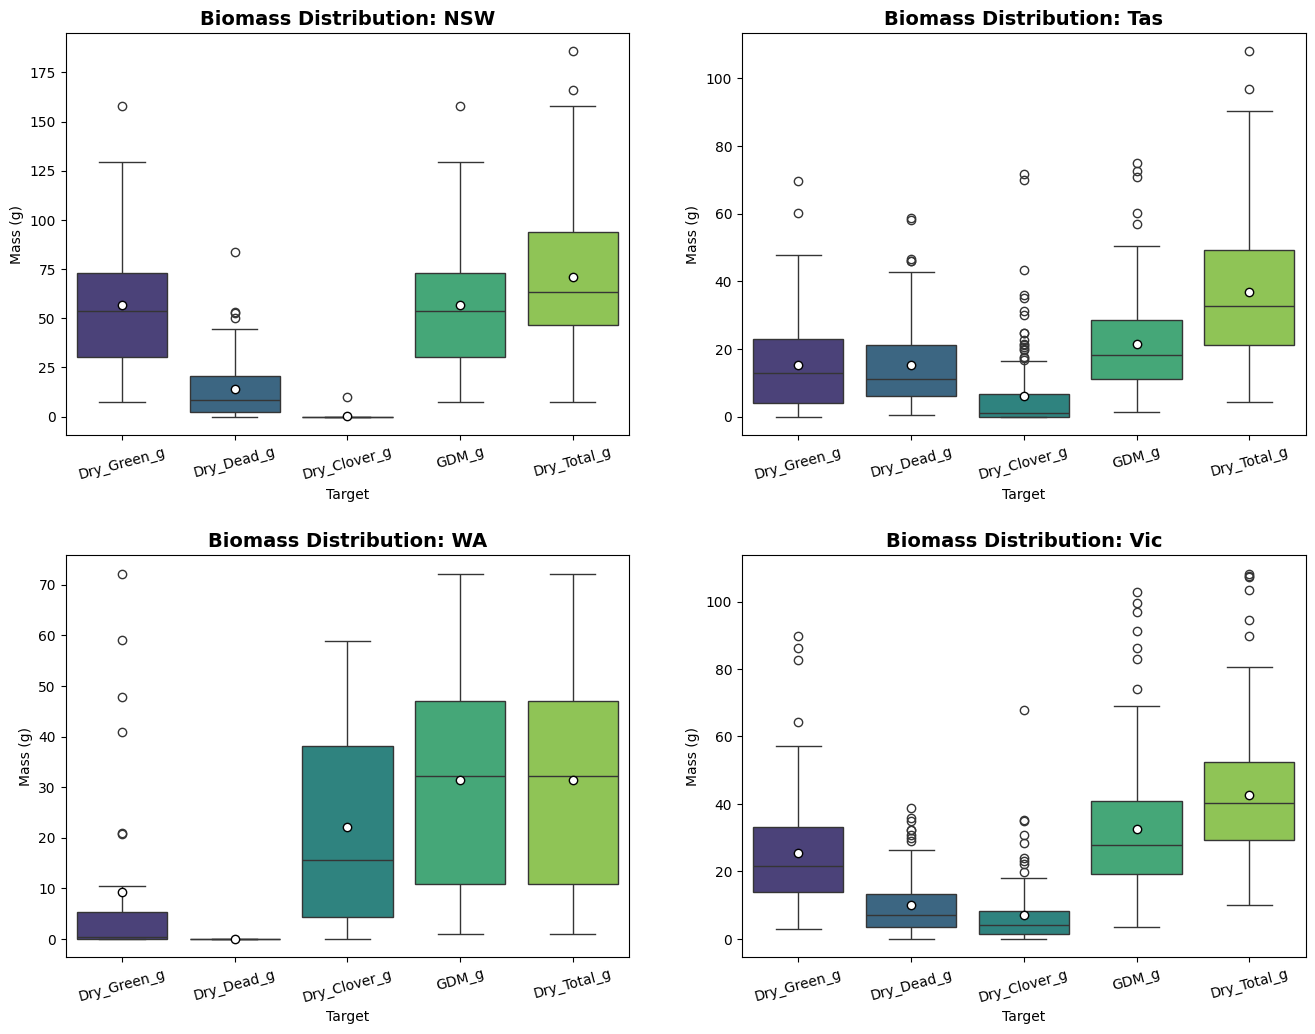

In [ ]:
STATES: Final[list[str]] = ["NSW", "Tas", "WA", "Vic"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
# Flatten the 2D array of axes into a 1D list for easy iteration
axes_flat = axes.flatten()

for i, state in enumerate(STATES):
    ax = axes_flat[i]
    state_col: str = f"State_{state}"

    state_df = combined_df[combined_df[state_col] == True]
    melted = state_df[TARGETS].melt(var_name="Target", value_name="Mass (g)")

    # 5. Create the boxplot
    sns.boxplot(
        data=melted,
        x="Target",
        y="Mass (g)",
        hue="Target",
        palette="viridis",
        ax=ax,
        showmeans=True,  # Adding mean marker for extra insight
        meanprops={
            "marker": "o",
            "markerfacecolor": "white",
            "markeredgecolor": "black",
        },
    )

    ax.set_title(f"Biomass Distribution: {state}", fontsize=14, fontweight="bold")
    ax.tick_params(axis="x", rotation=15)

    # Remove redundant legend (since target names are on X-axis)
    if ax.get_legend():
        ax.get_legend().remove()

    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.savefig("results/state_biomass_analysis.png")


## Test Time Augmentation (TTA) Visualization

Visualize how TTA tiles an image into a 2D grid for inference.

Image size: 2000x1000
Grid: 3 rows x 6 cols = 18 tiles
Tile size: 500x500
X positions: [0, 300, 600, 900, 1200, 1500]
Y positions: [0, 250, 500]


/var/folders/3y/wxw8br5d5s3gr0s6f06rbhb00000gp/T/ipykernel_24152/1551115111.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


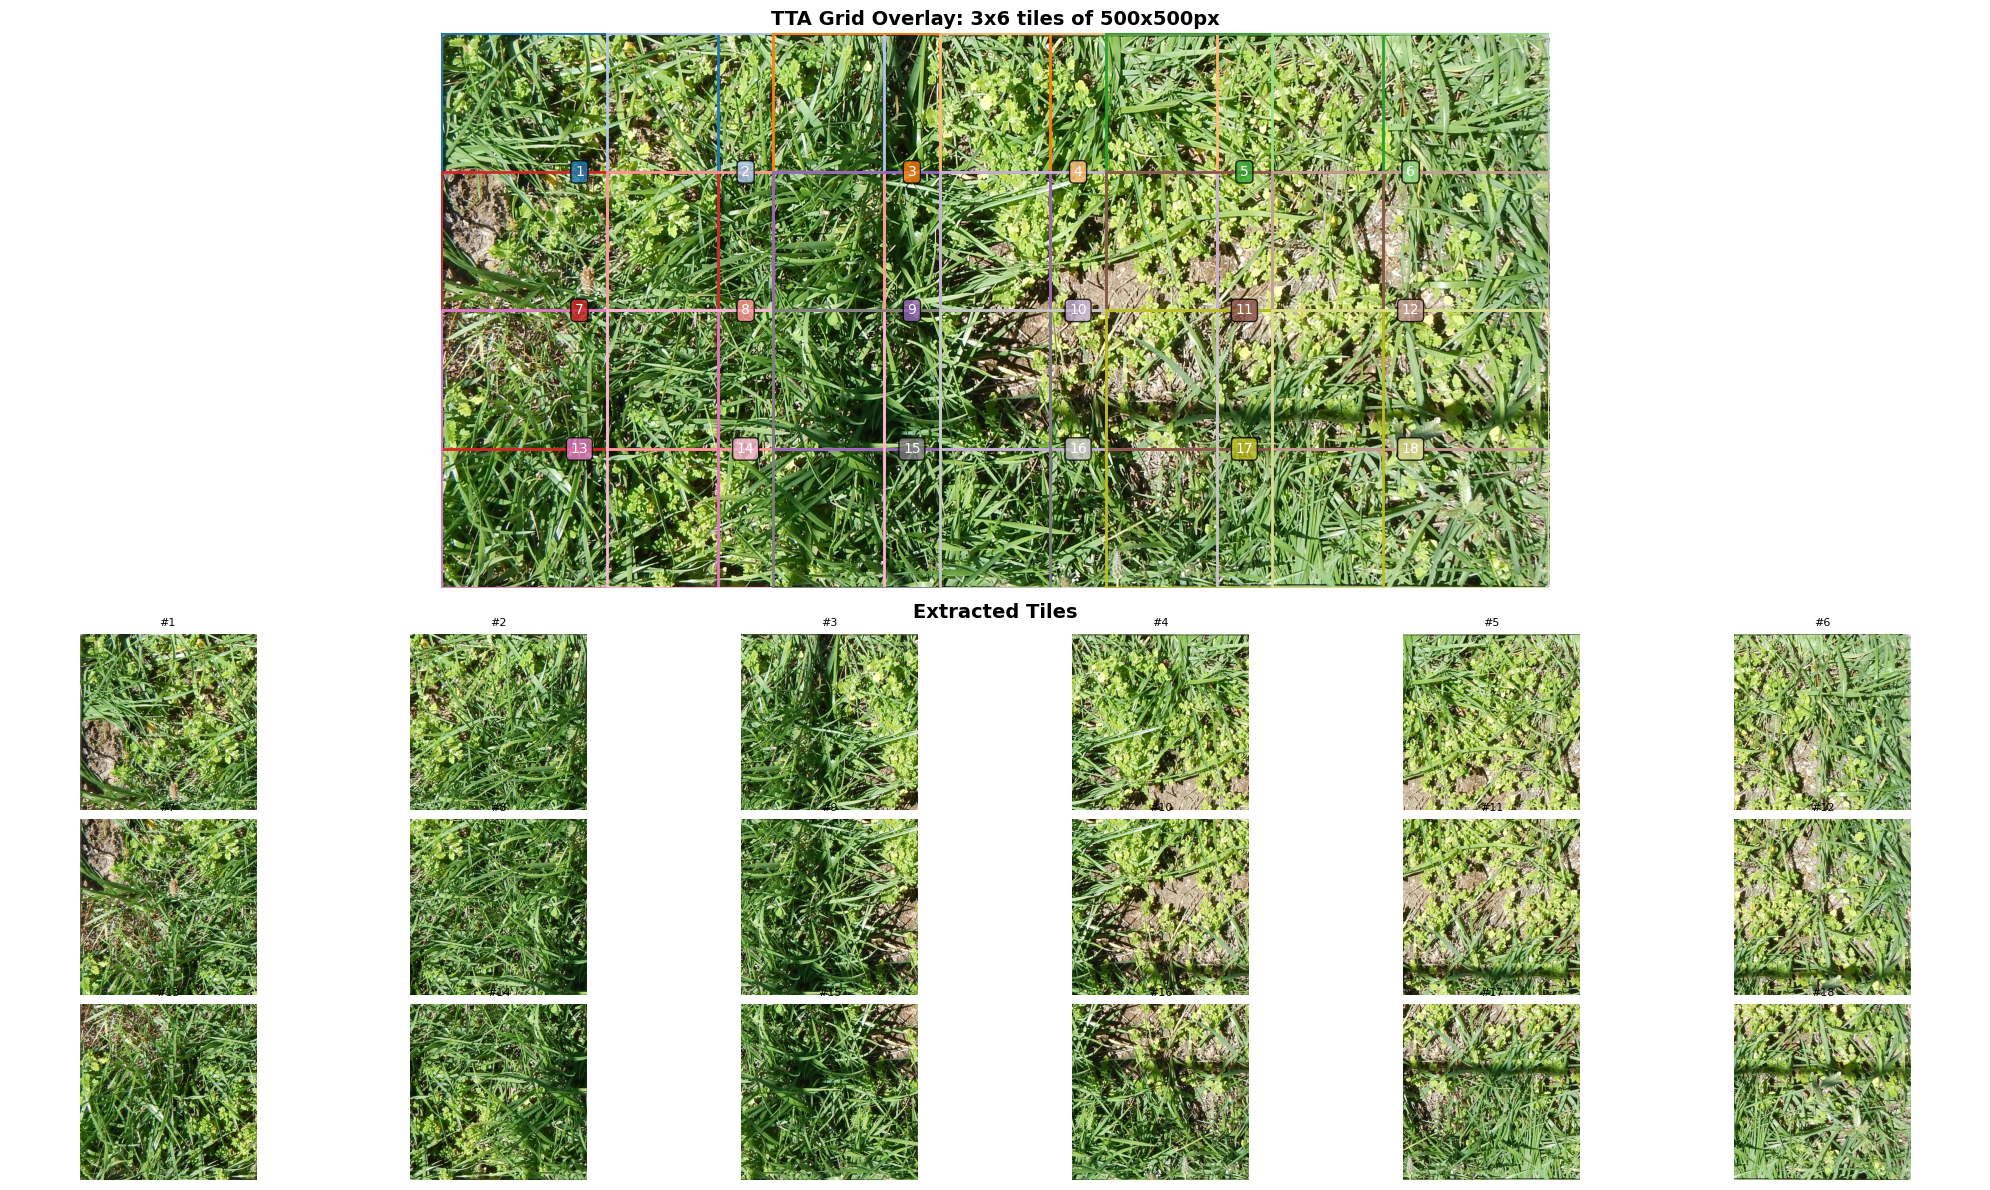

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import math
import os

# TTA parameters
tta_tiles = 18  # 3x6 grid
tile_size = 500

# Load a sample image
sample_img_path = "./data/train/" + os.listdir("./data/train/")[0]
img = Image.open(sample_img_path)
img_width, img_height = img.size

# Calculate grid dimensions (2x more columns than rows for 2000x1000 images)
n_rows = max(1, int(math.sqrt(tta_tiles / 2)))
n_cols = max(1, tta_tiles // n_rows)

# Calculate tile positions
max_x = max(0, img_width - tile_size)
max_y = max(0, img_height - tile_size)

x_positions = (
    [int(i * max_x / (n_cols - 1)) for i in range(n_cols)]
    if n_cols > 1
    else [max_x // 2]
)
y_positions = (
    [int(i * max_y / (n_rows - 1)) for i in range(n_rows)]
    if n_rows > 1
    else [max_y // 2]
)

print(f"Image size: {img_width}x{img_height}")
print(f"Grid: {n_rows} rows x {n_cols} cols = {n_rows * n_cols} tiles")
print(f"Tile size: {tile_size}x{tile_size}")
print(f"X positions: {x_positions}")
print(f"Y positions: {y_positions}")

# Create figure with two subplots
fig = plt.figure(figsize=(20, 12))

# 1. Show original image with tile grid overlay
ax1 = fig.add_subplot(2, 1, 1)
ax1.imshow(img)
ax1.set_title(
    f"TTA Grid Overlay: {n_rows}x{n_cols} tiles of {tile_size}x{tile_size}px",
    fontsize=14,
    fontweight="bold",
)

# Draw tile rectangles
colors = plt.cm.tab20(range(n_rows * n_cols))
tile_idx = 0
for row, y in enumerate(y_positions):
    for col, x in enumerate(x_positions):
        rect = patches.Rectangle(
            (x, y),
            tile_size,
            tile_size,
            linewidth=2,
            edgecolor=colors[tile_idx],
            facecolor="none",
            linestyle="-",
        )
        ax1.add_patch(rect)
        # Add tile number
        ax1.text(
            x + tile_size / 2,
            y + tile_size / 2,
            str(tile_idx + 1),
            fontsize=10,
            color="white",
            ha="center",
            va="center",
            bbox=dict(boxstyle="round", facecolor=colors[tile_idx], alpha=0.8),
        )
        tile_idx += 1

ax1.set_xlim(0, img_width)
ax1.set_ylim(img_height, 0)
ax1.axis("off")

# 2. Show extracted tiles in a grid
ax2 = fig.add_subplot(2, 1, 2)
ax2.axis("off")
ax2.set_title("Extracted Tiles", fontsize=14, fontweight="bold")

# Create a grid of tile images
tile_grid = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.1)
tiles_grid = tile_grid[1].subgridspec(n_rows, n_cols, wspace=0.05, hspace=0.05)

tile_idx = 0
for row, y in enumerate(y_positions):
    for col, x in enumerate(x_positions):
        ax = fig.add_subplot(tiles_grid[row, col])
        tile = img.crop((x, y, x + tile_size, y + tile_size))
        ax.imshow(tile)
        ax.set_title(f"#{tile_idx + 1}", fontsize=8)
        ax.axis("off")
        tile_idx += 1

plt.tight_layout()
plt.savefig("./results/tta_visualization.png", bbox_inches="tight", dpi=150)
plt.show()